In [1]:
from pathlib import Path
import json

from matplotlib import pyplot as plt
import pandas as pd


In [30]:
text = Path("../Report/images/tensorboard-eval.har").read_text()
har = json.loads(text)

text_set = set(
    entry["response"]["content"]["text"]
    for entry in filter(
        lambda entry: entry["request"]["url"].endswith("timeSeries"),
        har["log"]["entries"],
    )
)

data = [json.loads(text)[0] for text in text_set]


In [31]:
dump = {"Accuracy": {}, "LR": {}}

for obj in data:
    if obj["tag"] == "Loss/test":
        continue

    tag = obj["tag"].split("/")[0]
    for key, val in obj["runToSeries"].items():

        exp_id = key.split("/")[1]
        if exp_id.startswith("MultiStepLR"):
            sched = "MultiStepLR"
        elif exp_id.startswith('OneCycleLR'):
            sched = "OneCycleLR"
        else:
            continue

        opt = key.split("-")[-1]

        step = [item["step"] for item in val]
        value = [item["value"] for item in val]
        dump[tag][f"{opt}/{sched}"] = pd.Series(data=value, index=step)

accuracy = pd.DataFrame(dump["Accuracy"])
lr = pd.DataFrame(dump["LR"])


In [32]:
lr


,SGD/OneCycleLR,RAdam/OneCycleLR,Adam/OneCycleLR,RAdam/MultiStepLR,Adam/MultiStepLR,AdamW/MultiStepLR,SGD/MultiStepLR,AdamW/OneCycleLR
3,4.949684e-03,2.856087e-05,2.029414e-05,0.000713,0.000506,0.000498,0.123505,1.993860e-05
4,4.955019e-03,2.859165e-05,2.031601e-05,0.000713,0.000506,0.000498,0.123505,1.996009e-05
10,5.011913e-03,2.891995e-05,2.054928e-05,0.000713,0.000506,0.000498,0.123505,2.018928e-05
14,5.073528e-03,2.927548e-05,2.080191e-05,0.000713,0.000506,0.000498,0.123505,2.043748e-05
15,5.091890e-03,2.938143e-05,2.087719e-05,0.000713,0.000506,0.000498,0.123505,2.051144e-05
...,...,...,...,...,...,...,...,...
2335,7.731915e-06,4.461501e-08,3.170153e-08,0.000128,0.000081,0.000081,0.034392,3.114614e-08
2340,1.511866e-06,8.723831e-09,6.198783e-09,0.000128,0.000081,0.000081,0.034392,6.090185e-09
2342,6.071143e-07,3.503196e-09,2.489222e-09,0.000128,0.000081,0.000081,0.034392,2.445612e-09
2343,4.940200e-07,2.850614e-09,2.025525e-09,0.000128,0.000081,0.000081,0.034392,1.990040e-09


In [46]:
accuracy * 100

,SGD/OneCycleLR,RAdam/OneCycleLR,Adam/OneCycleLR,RAdam/MultiStepLR,Adam/MultiStepLR,AdamW/MultiStepLR,SGD/MultiStepLR,AdamW/OneCycleLR
469,91.530001,88.450003,90.140003,91.009998,93.250000,93.239999,95.560002,90.130001
938,96.289998,93.970001,94.559997,93.809998,95.120001,95.020002,97.280002,94.510001
1407,97.320002,95.840001,96.380001,94.959998,96.100003,96.060002,97.670001,96.350002
1876,97.920001,96.569997,96.829998,95.709997,96.420002,96.340001,98.159999,96.820003
2345,98.030001,96.710002,96.929997,96.200001,96.689999,96.660000,98.210001,96.890002


In [69]:
def plot(ax1, opt, ymax):
    ax1.set_title(opt)
    ax2 = ax1.twinx()

    yAcc = accuracy[opt] * 100
    ax1.set_ylabel("Accuracy (%)")

    yLR = lr[opt].copy()
    ax2.set_ylabel("Learning Rate")

    if ymax > 0.01:
        ymax *= 10
        yLR *= 10
        ax2.set_ylabel("Learning Rate (x0.1)")

    if ymax <= 0.001:
        ymax *= 1000
        yLR *= 1000
        ax2.set_ylabel("Learning Rate (x0.001)")

    # lr_range = locate_lr_range(opt)
    # ax1.fill_between(lr_range.index, 1.4, 2.4, alpha=0.36)

    ax1.plot(yAcc, label="Accuracy")
    ax2.step(yLR.index, yLR, color="orange", label="LR")

    ax1.set_xlim(0, 2400)
    ax1.set_ylim(80, 100)
    ax2.set_ylim(0, ymax)

    # ax1.grid(axis="x")
    ax2.grid()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")


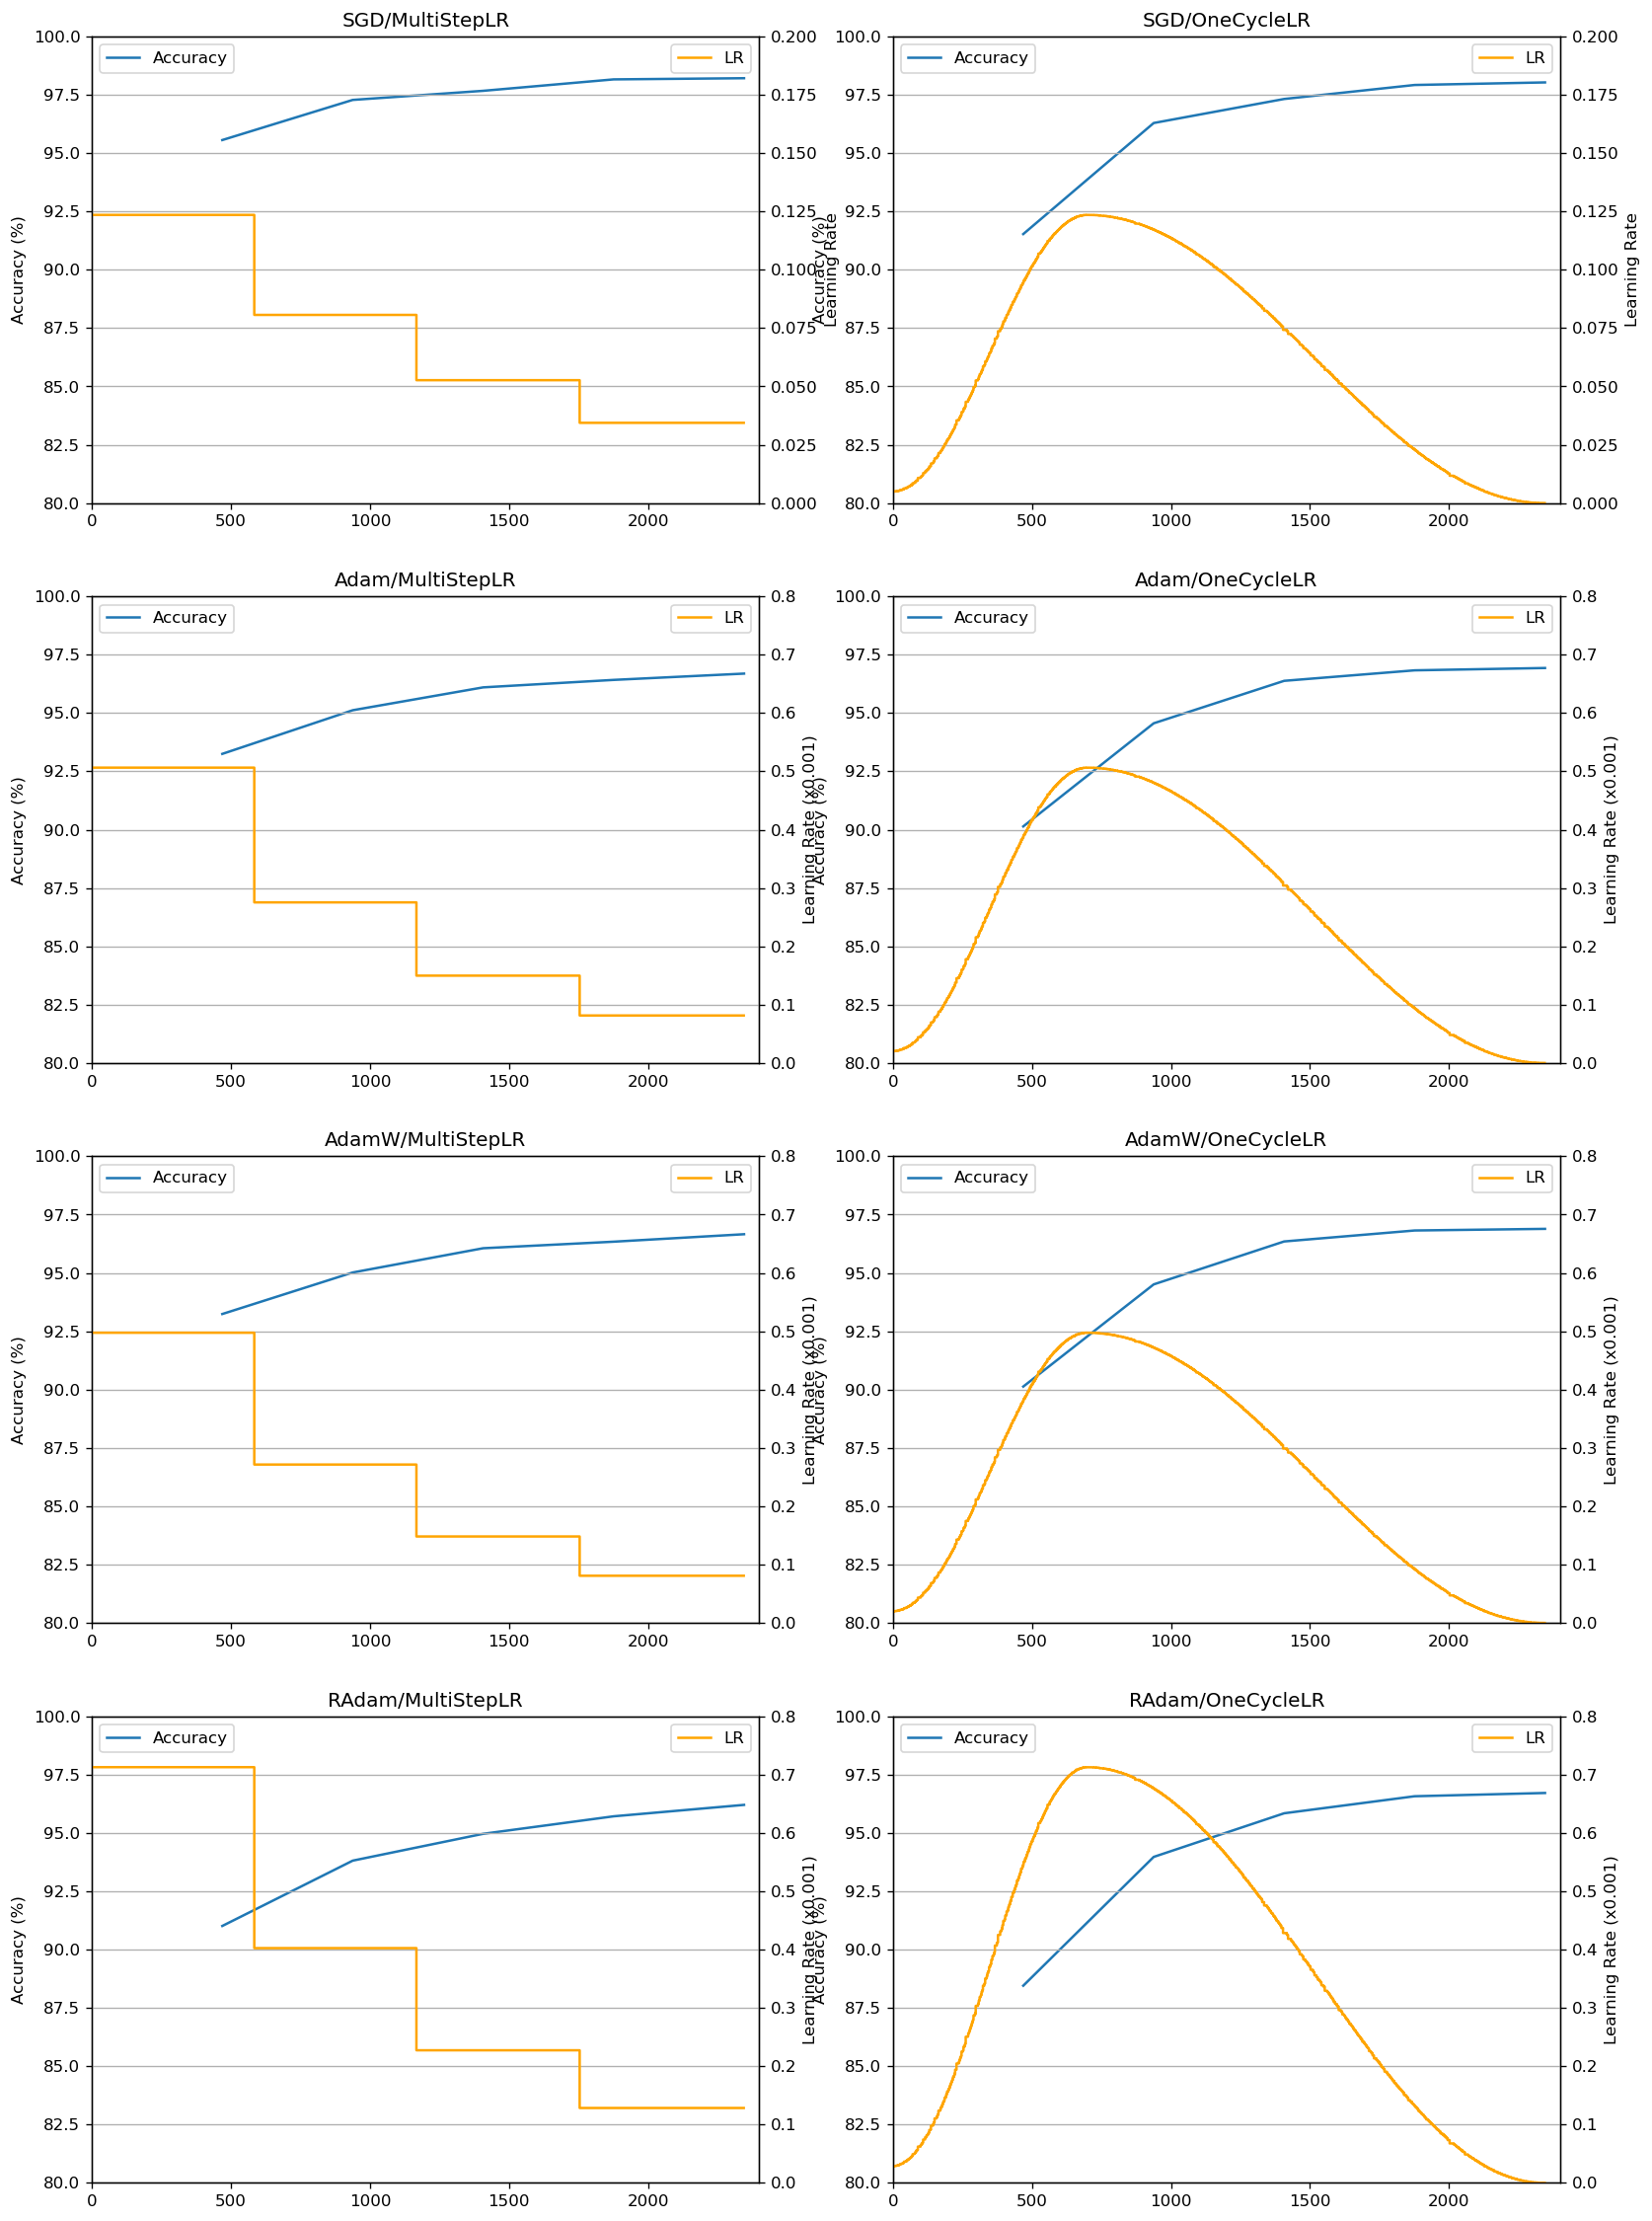

In [70]:
fix, axes = plt.subplots(4, 2, figsize=(16, 24), dpi=120)

plot(axes[0][0], "SGD/MultiStepLR", 0.2)
plot(axes[0][1], "SGD/OneCycleLR", 0.2)
plot(axes[1][0], "Adam/MultiStepLR", 0.0008)
plot(axes[1][1], "Adam/OneCycleLR", 0.0008)
plot(axes[2][0], "AdamW/MultiStepLR", 0.0008)
plot(axes[2][1], "AdamW/OneCycleLR", 0.0008)
plot(axes[3][0], "RAdam/MultiStepLR", 0.0008)
plot(axes[3][1], "RAdam/OneCycleLR", 0.0008)


In [66]:
# BASE = Path("../Report/images")

# fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
# plot(ax, "SGD", 1)
# fig.tight_layout()
# fig.savefig(BASE / "lr_range_sgd.pdf")

# fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
# plot(ax, "Adam", 0.0025)
# fig.tight_layout()
# fig.savefig(BASE / "lr_range_adam.pdf")

# fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
# plot(ax, "AdamW", 0.0025)
# fig.tight_layout()
# fig.savefig(BASE / "lr_range_adamw.pdf")

# fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
# plot(ax, "RAdam", 0.01)
# fig.tight_layout()
# fig.savefig(BASE / "lr_range_radam.pdf")
